In [1]:
#https://www.tensorflow.org/tutorials/images/transfer_learning#data_preprocessing

In [2]:
import pandas as pd
import numpy as np
import math

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold

In [4]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Flatten,MaxPooling2D,Dropout,Dense,Activation,BatchNormalization

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [6]:
from tqdm import tqdm
from tabulate import tabulate
from matplotlib import pyplot as plt

In [7]:
# selecting random number of images from multiple folders and copying it to the destination folder
# Combined Prediction (take new sample and make combine data)

import os
import shutil
import glob
import random

# 84
# ctscan_covid_data = random.sample(glob.glob("Custom_Data/CT_Scan/Covid/CT_COVID/*.png"), 330)
# ctscan_normal_data = random.sample(glob.glob("Custom_Data/CT_Scan/Normal/CT_nonCOVID/*"), 330)

# <50
# ultrasound_covid_data = random.sample(glob.glob("Custom_Data/ultrasound/Covid/*"), 330)
# ultrasound_normal_data = random.sample(glob.glob("Custom_Data/ultrasound/Normal/*.jpg"), 330)

# >90
# xray_covid_data = random.sample(glob.glob("Custom_Data/X_ray/Covid/*.png"), 330)
# xray_normal_data = random.sample(glob.glob("Custom_Data/X_ray/Normal/*.png"), 330)

#ctscan_covid_data = random.sample(glob.glob("Hamza_Custom_Data/CT_Scan/Covid/*.png"), 330)
#ctscan_normal_data = random.sample(glob.glob("Hamza_Custom_Data/CT_Scan/Normal/*"), 330)   

ultrasound_covid_data = random.sample(glob.glob("Hamza_Custom_Data/Ultra_Sound/Covid/*"), 330)
ultrasound_normal_data = random.sample(glob.glob("Hamza_Custom_Data/Ultra_Sound/Normal/*.jpg"), 330)

# xray_covid_data = random.sample(glob.glob("Hamza_Custom_Data/X_Ray/Covid/*.png"), 330)
# xray_normal_data = random.sample(glob.glob("Hamza_Custom_Data/X_Ray/Normal/*.png"), 330)

# covid_list=[ctscan_covid_data,ultrasound_covid_data,xray_covid_data] #combined
covid_list=[ultrasound_covid_data] #solo


# normal_list = [ctscan_normal_data, ultrasound_normal_data,xray_normal_data] #combined
normal_list = [ultrasound_normal_data] #solo


if os.path.isdir('Data/Covid'):
    shutil.rmtree('Data/Covid')
    
if os.path.isdir('Data/Normal'):
    shutil.rmtree('Data/Normal')

for data in covid_list:
    dest = 'Data/Covid'
    if not os.path.isdir('Data/Covid'):
        os.makedirs(dest)
    for imgs in data:
        shutil.copy(imgs, dest)

for data in normal_list:
    dest = 'Data/Normal' 
    if not os.path.isdir('Data/Normal'):
          os.makedirs(dest)
    for imgs in data:
        shutil.copy(imgs, dest)

In [8]:
# pre-processing (image shape)
# X shape in 3 dimensions
# Y has 2 classes (Covid, Normal)
# make train and test data

class Dataset:
    def __init__(self, data_root: str, *, test_size: float, img_size: int, seed: int = 0) -> None:
        self.label2index = {}
        self.index2label = {}
        
        # Discover the class label names.
        class_labels = os.listdir(data_root)
        self.nclasses = len(class_labels)
        X, y = [], []
        
        for label_index, label in enumerate(class_labels):
            # Load the images for this class label.
            self.label2index[label_index] = label
            self.index2label[label] = label_index
            
            img_names = os.listdir(os.path.join(data_root, label))
            for img_name in img_names:
                img_path = os.path.join(data_root, label, img_name)
                img = load_img(img_path, target_size=(img_size, img_size, 3))
                X.append(img_to_array(img))
                y.append(label_index)
        
        X = np.array(X)
        y = np.array(y)
        one_hot_y = to_categorical(y, num_classes=self.nclasses)
        
        # Make a stratified split.
        self.X_train, self.X_test, self.labels_train, self.labels_test, self.y_train, self.y_test = train_test_split(
            X, y, one_hot_y, test_size=test_size, random_state=seed, stratify=y)

In [9]:
# (660*3) * 0.7 = 1386
import os
import shutil
import glob
import random
data = Dataset("Data/", test_size=0.2, img_size=224) #check test size
print(data.X_train.shape, data.y_train.shape)
print(data.X_test.shape, data.y_test.shape)

(528, 224, 224, 3) (528, 2)
(132, 224, 224, 3) (132, 2)


In [10]:
print(data.X_train.shape[1:4])

(224, 224, 3)


In [11]:
nas_model = tf.keras.applications.nasnet.NASNetMobile(input_shape=data.X_train.shape[1:4], include_top=False, weights='imagenet')

In [12]:
# feature extractor model resnet 101 v2
# model = hub.KerasLayer("https://tfhub.dev/google/bit/m-r101x1/1", trainable=False)

In [13]:
covid_train_embedding = nas_model(data.X_train) # Nasnet


print(covid_train_embedding.shape)

(528, 7, 7, 1056)


In [14]:
##resnet
# resnet_model.trainable = False
# resnet_model.summary()

In [15]:
## Mobinet
nas_model.trainable = False
nas_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

__________________________________________________________________________________________________
separable_conv_2_bn_normal_righ (None, 28, 28, 44)   176         separable_conv_2_normal_right1_1[
__________________________________________________________________________________________________
separable_conv_2_bn_normal_left (None, 28, 28, 44)   176         separable_conv_2_normal_left2_1[0
__________________________________________________________________________________________________
separable_conv_2_bn_normal_righ (None, 28, 28, 44)   176         separable_conv_2_normal_right2_1[
__________________________________________________________________________________________________
normal_left3_1 (AveragePooling2 (None, 28, 28, 44)   0           normal_bn_1_1[0][0]              
__________________________________________________________________________________________________
normal_left4_1 (AveragePooling2 (None, 28, 28, 44)   0           adjust_bn_1[0][0]                
__________

separable_conv_1_normal_right1_ (None, 14, 14, 88)   8536        activation_96[0][0]              
__________________________________________________________________________________________________
separable_conv_1_normal_left2_6 (None, 14, 14, 88)   9944        activation_98[0][0]              
__________________________________________________________________________________________________
separable_conv_1_normal_right2_ (None, 14, 14, 88)   8536        activation_100[0][0]             
__________________________________________________________________________________________________
separable_conv_1_normal_left5_6 (None, 14, 14, 88)   8536        activation_102[0][0]             
__________________________________________________________________________________________________
separable_conv_1_bn_normal_left (None, 14, 14, 88)   352         separable_conv_1_normal_left1_6[0
__________________________________________________________________________________________________
separable_

normal_concat_8 (Concatenate)   (None, 14, 14, 528)  0           adjust_bn_8[0][0]                
                                                                 normal_add_1_8[0][0]             
                                                                 normal_add_2_8[0][0]             
                                                                 normal_add_3_8[0][0]             
                                                                 normal_add_4_8[0][0]             
                                                                 normal_add_5_8[0][0]             
__________________________________________________________________________________________________
activation_129 (Activation)     (None, 14, 14, 528)  0           normal_concat_8[0][0]            
__________________________________________________________________________________________________
activation_128 (Activation)     (None, 14, 14, 528)  0           normal_concat_7[0][0]            
__________

__________________________________________________________________________________________________
normal_add_1_12 (Add)           (None, 7, 7, 176)    0           separable_conv_2_bn_normal_left1_
                                                                 separable_conv_2_bn_normal_right1
__________________________________________________________________________________________________
normal_add_2_12 (Add)           (None, 7, 7, 176)    0           separable_conv_2_bn_normal_left2_
                                                                 separable_conv_2_bn_normal_right2
__________________________________________________________________________________________________
normal_add_3_12 (Add)           (None, 7, 7, 176)    0           normal_left3_12[0][0]            
                                                                 adjust_bn_12[0][0]               
__________________________________________________________________________________________________
normal_add

In [16]:
# BATCH_SIZE = 32
# IMG_SIZE = (224, 224)
# dataset = tf.keras.utils.image_dataset_from_directory("Data",
#                                                       shuffle=True,
#                                                       batch_size=BATCH_SIZE,
#                                                       image_size=IMG_SIZE)

In [17]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [18]:

preprocess_input = tf.keras.applications.nasnet.preprocess_input ## Mobinet



In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(covid_train_embedding)
print(feature_batch_average.shape)

(528, 1056)


In [20]:
prediction_layer = tf.keras.layers.Dense(2)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(528, 2)


In [21]:
data.X_train.shape[1:4]

(224, 224, 3)

In [22]:
# Model

inputs = tf.keras.Input(shape=(data.X_train.shape[1:4]))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = nas_model(x, training=False)
#x = resnet_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [23]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1056)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1056)              0     

In [25]:
len(model.trainable_variables)

2

In [26]:
print(covid_train_embedding.shape)
print(feature_batch_average.shape)

(528, 7, 7, 1056)
(528, 1056)


In [27]:
# X_train_val = covid_train_embedding
# y_train_val = data.y_train
# data_train_labels = data.labels_train

In [28]:
# X_test_val = covid_test_embedding
# y_test_val = data.y_test
# data_test_labels = data.labels_test

In [29]:
# # Chaning shape for CNN2D
# # for 2048 - > [-1,2,2,512]
# # for 1280 - > [-1,2,2,320]

# covid_train_embedding2d = tf.reshape(feature_batch_average, [-1,2,2,320])
# print(covid_train_embedding2d.shape)

# covid_test_embedding2d = tf.reshape(feature_batch_average, [-1,2,2,320])
# print(covid_test_embedding2d.shape)

# X_train_val = covid_train_embedding2d
# X_test_val = covid_test_embedding2d

In [30]:
initial_epochs = 20
history = model.fit(data.X_train, data.y_train, epochs=initial_epochs, validation_data=(data.X_test, data.y_test))

Epoch 1/20
17/17 [==============================] - 66s 3s/step - loss: 0.7504 - accuracy: 0.5417 - val_loss: 0.7373 - val_accuracy: 0.4318
Epoch 2/20
17/17 [==============================] - 42s 2s/step - loss: 0.7060 - accuracy: 0.5568 - val_loss: 0.7144 - val_accuracy: 0.4394
Epoch 3/20
17/17 [==============================] - 42s 3s/step - loss: 0.6826 - accuracy: 0.5890 - val_loss: 0.7015 - val_accuracy: 0.4848
Epoch 4/20
17/17 [==============================] - 42s 3s/step - loss: 0.6548 - accuracy: 0.6742 - val_loss: 0.6894 - val_accuracy: 0.5682
Epoch 5/20
17/17 [==============================] - 43s 3s/step - loss: 0.6205 - accuracy: 0.7064 - val_loss: 0.6803 - val_accuracy: 0.6136
Epoch 6/20
17/17 [==============================] - 42s 2s/step - loss: 0.6030 - accuracy: 0.7386 - val_loss: 0.6703 - val_accuracy: 0.6364
Epoch 7/20
17/17 [==============================] - 45s 3s/step - loss: 0.5944 - accuracy: 0.7367 - val_loss: 0.6600 - val_accuracy: 0.6439
Epoch 8/20
17/17 [==

In [31]:
data.y_test.shape

(132, 2)

In [32]:
loss0, accuracy0 = model.evaluate(data.X_test, data.y_test)

5/5 [==============================] - 12s 1s/step - loss: 0.5951 - accuracy: 0.6970


In [33]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.60
initial accuracy: 0.70


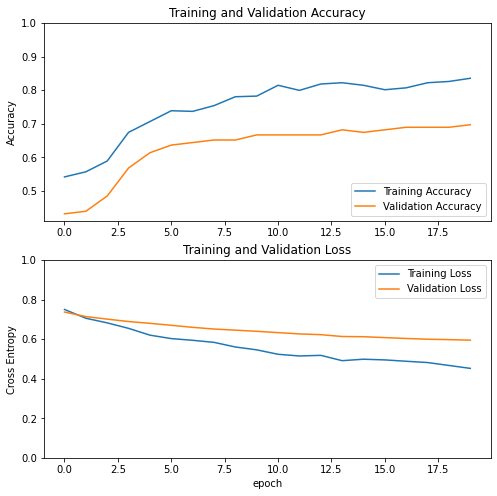

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine Tuning 

In [35]:
nas_model.trainable = True 

In [36]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(nas_model.layers)) ##nasnet


# Fine-tune from this layer onwards
fine_tune_at = 500 ## nasnet


# Freeze all the layers before the `fine_tune_at` layer
for layer in nas_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  769


In [37]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1056)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1056)              0     

In [39]:
len(model.trainable_variables)

267

In [40]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(data.X_train, data.y_train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=(data.X_test, data.y_test))

Epoch 20/50
17/17 [==============================] - 86s 3s/step - loss: 0.4158 - accuracy: 0.8201 - val_loss: 0.5363 - val_accuracy: 0.7197
Epoch 21/50
17/17 [==============================] - 53s 3s/step - loss: 0.3378 - accuracy: 0.8826 - val_loss: 0.4961 - val_accuracy: 0.7500
Epoch 22/50
17/17 [==============================] - 53s 3s/step - loss: 0.2862 - accuracy: 0.8864 - val_loss: 0.5332 - val_accuracy: 0.7348
Epoch 23/50
17/17 [==============================] - 52s 3s/step - loss: 0.2806 - accuracy: 0.9053 - val_loss: 0.5121 - val_accuracy: 0.7500
Epoch 24/50
17/17 [==============================] - 52s 3s/step - loss: 0.2473 - accuracy: 0.9072 - val_loss: 0.3906 - val_accuracy: 0.8409
Epoch 25/50
17/17 [==============================] - 52s 3s/step - loss: 0.2277 - accuracy: 0.9034 - val_loss: 0.4114 - val_accuracy: 0.8258
Epoch 26/50
17/17 [==============================] - 52s 3s/step - loss: 0.1912 - accuracy: 0.9318 - val_loss: 0.3487 - val_accuracy: 0.8561
Epoch 27/50
1

In [41]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

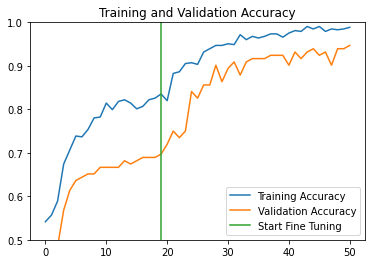

In [42]:
plt.figure(figsize=(6, 4))
plt.subplot()
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')



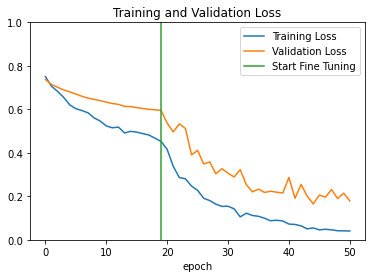

In [43]:
plt.figure(figsize=(6, 4))
plt.plot()
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [44]:
eval_loss, accuracy = model.evaluate(data.X_test, data.y_test)
print('Test accuracy :', accuracy)

5/5 [==============================] - 7s 1s/step - loss: 0.1791 - accuracy: 0.9470
Test accuracy : 0.9469696879386902


In [45]:
y_pred = model.predict(data.X_test)
y_pred1 = np.argmax(y_pred, axis=1)
y_test1 = np.argmax(data.y_test, axis=1)

print(accuracy_score(y_test1, y_pred1))
print(confusion_matrix(y_test1,y_pred1))
print(classification_report(y_test1,y_pred1))

0.946969696969697
[[61  5]
 [ 2 64]]
              precision    recall  f1-score   support

           0       0.97      0.92      0.95        66
           1       0.93      0.97      0.95        66

    accuracy                           0.95       132
   macro avg       0.95      0.95      0.95       132
weighted avg       0.95      0.95      0.95       132

